# 第11章　画風変換

**共通モジュールの読み込み**

In [1]:
import os
import math
import numpy as np
from tensorflow.python.keras.preprocessing.image import load_img,  img_to_array, array_to_img

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**リスト11.1:ResidualBlockを作成する関数の定義**

In [2]:
from tensorflow.python.keras.layers import Conv2D,  BatchNormalization, Add, Activation

def residual_block(input_ts):
    """ResidualBlockの構築する関数"""
    # Conv -> BN -> RELU -> Conv -> BN
    x = Conv2D(
        128, (3, 3), strides=1, padding='same'
    )(input_ts)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x) #  チャネル数と画像サイズはinput_tsと同じ
    return Add()([x, input_ts]) 

**リスト11.2:変換ネットワークを構築するencoder・decoder 関数の定義**

In [3]:
from tensorflow.python.keras.layers import Input,  Lambda, Conv2DTranspose
from tensorflow.python.keras.models import Model


def build_encoder_decoder(input_shape=(224, 224, 3)):
    """変換用ネットワークの構築"""

    # Encoder部分
    input_ts = Input(shape=input_shape, name='input')

    # 入力を[0, 1]の範囲に正規化
    x = Lambda(lambda a: a/255.)(input_ts)

    x = Conv2D(32, (9, 9), strides=1, padding='same')(x) # 9x9の大きいフィルタ
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same')(x) # チャネル数を倍に増やす、画像サイズは半分(stride=2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), strides=2, padding='same')(x) # チャネル数を倍に増やす、画像サイズは半分(stride=2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # ResidualBlockを5ブロック追加
    for _ in range(5):
        x = residual_block(x)

    # Decoder部分
    x = Conv2DTranspose(
            64, (3, 3), strides=2, padding='same' # チャンネル数を半分、画像サイズを倍にする(stride=2)
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x) # チャンネル数を半分、画像サイズを倍にする(stride=2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(3, (9, 9), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x) # -1〜+1に丸める

    # 出力値が[0, 255]になるようにスケール変換
    gen_out = Lambda(lambda a: (a + 1)*127.5)(x)

    model_gen = Model(
        inputs=[input_ts], 
        outputs=[gen_out]
    )

    return model_gen

input_shape = (224, 224, 3)

# 変換ネットワークの構築 （いわゆる生成ネットワーク）
model_gen = build_encoder_decoder(
    input_shape=input_shape
)

**リスト11.3:学習用ネットワークの構築**

In [4]:
from tensorflow.python.keras.applications.vgg16 import VGG16


# 学習済みモデルVGG16の呼び出し
vgg16 = VGG16()

# 重みパラメータを学習させない設定をする
for layer in vgg16.layers:
    layer.trainable = False

# VGG16のための入力値を正規化する関数
def norm_vgg16(x):
        """RGB->BGR変換と近似的に中心化をおこなう関数"""
        return (x[:, :, :, ::-1]  - 120)/255.
    
# 特徴量を抽出する層の名前を定義
style_layer_names = (
    'block1_conv2', 
    'block2_conv2', 
    'block3_conv3', 
    'block4_conv3'
)
contents_layer_names = ('block3_conv3',)

# 中間層の出力を保持するためのリスト
style_outputs_gen = []
contents_outputs_gen = []

input_gen = model_gen.output  # 変換ネットワークの出力を入力とする
z = Lambda(norm_vgg16)(input_gen)  # 入力値の正規化
for layer in vgg16.layers:
    z = layer(z)  # VGG16の層を積み上げてネットワークを再構築
    if layer.name in style_layer_names:
        # スタイル特徴量抽出用の中間層の出力を追加
        style_outputs_gen.append(z)
    if layer.name in contents_layer_names:
        # コンテンツ特徴量抽出用の中間層の出力を追加
        contents_outputs_gen.append(z)

# モデルを定義 （変換ネットワーク+学習ネットワーク）
model = Model(
      inputs=model_gen.input, # 変換ネットワークへの入力がこのネットワークへの入力にもなる
      outputs=style_outputs_gen + contents_outputs_gen
)

553467904/553467096 [==============================]553467904/553467096 [==============================] - 8s 0us/step



**リスト11.4:スタイルの手本となる画像の読み込み**

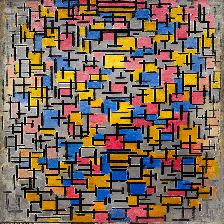

In [5]:
input_size = input_shape[:2] # 224x224

# スタイル画像の読み込み
img_sty = load_img(
    'img/style/Piet_Mondrian_Composition.png', 
    target_size=input_size
)

# スタイル画像の表示
img_sty

**リスト11.5:スタイルの手本となる画像をnumpy.ndarrayに変換**

In [6]:
# 読み込んだ画像をnumpy.ndarrayに変換
img_arr_sty = np.expand_dims(img_to_array(img_sty), axis=0) # (1, 224, 224, 3)

**リスト11.6：手本となる画像のスタイル特徴量の抽出**

In [7]:
# 入力層の定義
input_sty = Input(shape=input_shape, name='input_sty')

style_outputs = []  # 中間層の出力を保持するリスト
x = Lambda(norm_vgg16)(input_sty) # VGG16のための入力値を正規化する 
for layer in vgg16.layers: 
    x = layer(x) # 学習済みVGGモデルのレイヤを適用していく
    if layer.name in style_layer_names:
        style_outputs.append(x)

# スタイルの手本となる画像を入力して、特徴量を出力するモデルを定義
model_sty = Model(
    inputs=input_sty, 
    outputs=style_outputs
)

# 手本画像から正解データとなる特徴量を抽出
y_true_sty = model_sty.predict(img_arr_sty) # (1, 224, 224, 64) のリスト(4個)

**コンテンツの手本となる特徴量抽出用ネットワーク構築**

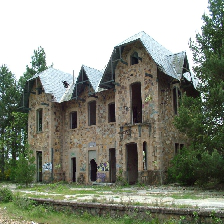

In [8]:
# コンテンツ画像の読み込み
img_con = load_img(
    'img/context/fa076ee97e8f2c40.jpg', 
    target_size=input_size
)

# スタイル画像の表示
img_con

**リスト11.7:手本となる画像のコンテンツ特徴量の抽出用ネットワーク構築**

In [9]:
# 入力層の定義
input_con = Input(shape=input_shape, name='input_con')

contents_outputs = [] # 中間層の出力を保持するリスト
y = Lambda(norm_vgg16)(input_con)
for layer in vgg16.layers:
    y = layer(y)
    if layer.name in contents_layer_names:
        contents_outputs.append(y)

# コンテンツの手本画像を入力して、特徴量を出力するモデルを定義　（手本画像はサンプル数だけ存在する）
model_con = Model(
    inputs=input_con, 
    outputs=contents_outputs
)

**リスト11.8:画像読み込み用の関数定義**

In [10]:
# 画像ファイル読み込み用のラッパー関数定義
def load_imgs(img_paths, target_size=(224, 224)):
    """画像ファイルのパスのリストから、配列のバッチを返す"""
    _load_img = lambda x: img_to_array(
        load_img(x, target_size=target_size)
    )
    img_list = [
        np.expand_dims(_load_img(img_path), axis=0)
        for img_path in img_paths
    ]
    return np.concatenate(img_list, axis=0) # (サンプル数, 224, 224, 3)

**リスト11.9:ジェネレータ用の関数定義**

In [28]:
import math


def train_generator(img_paths, batch_size, model, y_true_sty, shuffle=True, epochs=None):
    """学習データを生成するジェネレータ"""
    n_samples = len(img_paths)
    indices = list(range(n_samples))
    steps_per_epoch = math.ceil(n_samples / batch_size) # データセットのサンプル数をバッチサイズで割ったもの 
    cnt_epoch = 0
    while True:
        cnt_epoch += 1
        if shuffle:
            np.random.shuffle(indices)
        for i in range(steps_per_epoch):
            start = batch_size*i
            end = batch_size*(i + 1)
            X = load_imgs(img_paths[indices[start:end]]) # バッチサイズ分取り出す
            batch_size_act = X.shape[0] # 1バッチの画像の枚数
            y_true_sty_t = [ 
                np.repeat(feat, batch_size_act, axis=0)
                for feat in y_true_sty # スタイル特徴量（4つ）をそれぞれ画像の枚数分だけコピーする
            ]
            # コンテンツ特徴量の抽出
            y_true_con = model.predict(X) # コンテンツ
            yield (X,  y_true_sty_t + [y_true_con]) # バッチサイズ分の入力画像と（スタイル特徴量、コンテンツ特徴量）を返す
        if epochs is not None:
            if cnt_epoch >= epochs:
                raise StopIteration

**リスト11.10:ジェネレータの生成**

In [29]:
import glob


# 入力画像ファイルのパスを取得
path_glob = os.path.join('img/context/*.jpg')
img_paths = glob.glob(path_glob) # 10700枚
img_paths = np.array(img_paths) # np.ndarrayにしないと list indices must be integers or slices, not list のエラーが出る! (bug)

# バッチサイズとエポック数の設定
batch_size = 2
epochs = 10

# ジェネレータを生成
gen = train_generator(
    img_paths, 
    batch_size, 
    model_con, # コンテンツ特徴量の抽出用ネットワーク
    y_true_sty, # あらかじめ計算したスタイル特徴量
    epochs=epochs
)

**リスト11.11:コンテンツ特徴量の損失関数**

In [13]:
from tensorflow.python.keras import backend as K

def feature_loss(y_true, y_pred):
    """コンテンツ特徴量の損失関数"""
    # K.prod: テンソルに対して，指定した軸に沿って積を計算します．
    norm = K.prod(K.cast(K.shape(y_true)[1:], 'float32')) 
    return K.sum(
        K.square(y_pred - y_true), axis=(1, 2, 3)
    )/norm

**リスト11.12:スタイル特徴量の損失関数**

In [14]:
def gram_matrix(X):
    """グラム行列の算出"""
    X_sw = K.permute_dimensions(
        X, (0, 3, 2, 1)
    )  # 軸の入れ替え
    s = K.shape(X_sw)
    new_shape = (s[0], s[1], s[2]*s[3])
    X_rs = K.reshape(X_sw, new_shape)
    X_rs_t = K.permute_dimensions(
        X_rs, (0, 2, 1)
    )  # 行列の転置
    dot = K.batch_dot(X_rs, X_rs_t)  # 内積の計算
    norm = K.prod(K.cast(s[1:], 'float32'))
    return dot/norm

def style_loss(y_true, y_pred):
    """スタイル用の損失関数定義"""
    return K.sum(
        K.square(
            gram_matrix(y_pred) - gram_matrix(y_true)
        ),
        axis=(1, 2)
    )

**リスト11.13：モデルや結果を保存するディレクトリの準備**


In [15]:
import datetime


# モデルや結果を保存するディレクトリの準備
dt = datetime.datetime.now()
dir_log = 'model/{:%y%m%d_%H%M%S}'.format(dt)
dir_weights = 'model/{:%y%m%d_%H%M%S}/weights'.format(dt)
dir_trans = 'model/{:%y%m%d_%H%M%S}/img_trans'.format(dt)

os.makedirs(dir_log, exist_ok=True)
os.makedirs(dir_weights, exist_ok=True)
os.makedirs(dir_trans, exist_ok=True)

**Total Variation Regularizerの定義と正則化項の追加**

In [16]:
# Total Variation Regularizerの定義
def TVRegularizer(x, weight=1e-6, beta=1.0, input_size=(224, 224)):
    delta = 1e-8
    h, w = input_size
    d_h = K.square(x[:, :h - 1, :w - 1, :] - x[:, 1:, :w - 1, :])
    d_w = K.square(x[:, :h - 1, :w - 1, :] - x[:, :h - 1, 1:, :])
    return weight * K.mean(K.sum(K.pow(d_h + d_w + delta, beta/2.)))

# 正則化項を追加
use_tvr = True
if use_tvr:
    gen_output_layer = model_gen.layers[-1] # 変換ネットワークモデルの最終レイヤー
    tv_loss = TVRegularizer(gen_output_layer.output)
    gen_output_layer.add_loss(tv_loss) # 正則化項をロスに追加

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


**リスト11.14:モデルのコンパイル**

In [17]:
from tensorflow.python.keras.optimizers import Adadelta


# モデルのコンパイル
model.compile(
      optimizer=Adadelta(),
      loss=[ # モデルが複数の出力を持つ場合は，オブジェクトの辞書かリストを渡すことで，各出力に異なる損失を用いることができます． モデルによって最小化される損失値は全ての個々の損失の合計になります．s
            style_loss, 
            style_loss, 
            style_loss, 
            style_loss, 
            feature_loss
        ],
      loss_weights=[1.0, 1.0, 1.0, 1.0, 3.0]
)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


**リスト11.15:モデルの学習**

In [30]:
import pickle


# 学習中に画風変換の途中経過を確認するため
# 読み込んだ画像をnumpy.ndarrayに変換
img_test = load_img(
    'img/test/building.jpg', 
    target_size=input_size
)
img_arr_test = img_to_array(img_test)
img_arr_test = np.expand_dims(
    img_to_array(img_test), 
    axis=0
)

# エポックごとのバッチ数の計算
steps_per_epoch = math.ceil(len(img_paths)/batch_size)

iters_verbose = 1000
iters_save_img = 1000
iters_save_model = steps_per_epoch

# 学習実施
# 学習にはGPUを利用して、数時間かかる
now_epoch = 0
losses = []
path_tmp = 'epoch_{}_iters_{}_loss_{:.2f}_{}'
for i, (x_train, y_train) in enumerate(gen):
    
    if i % steps_per_epoch == 0:
        now_epoch += 1
    
    # 学習
    loss =  model.train_on_batch(x_train, y_train) # 1バッチ分の勾配を更新する
    losses.append(loss)

    # 学習経過の表示
    if i % iters_verbose == 0:
        print(
            'epoch:{}, iters:{}, loss:{:.3f}'.format(
                now_epoch, i, loss[0]
            )
        )

    # 画像の保存
    if i % iters_save_img == 0 :
        pred = model_gen.predict(img_arr_test)
        img_pred = array_to_img(pred.squeeze())
        path_trs_img = path_tmp.format(
            now_epoch, i, loss[0], '.jpg'
        )
        img_pred.save(
            os.path.join(
                dir_trans, 
                path_trs_img
            )
        )
        print('# image saved:{}'.format(path_trs_img))
    
    # モデル、損失の保存
    if i % iters_save_model == 0 :
        model.save(
            os.path.join(
                dir_weights, 
                path_tmp.format(
                    now_epoch, i, loss[0], '.h5'
                )
            )
        )
        path_loss = os.path.join(dir_log, 'loss.pkl')
        with open(path_loss, 'wb') as f:
            pickle.dump(losses, f)

epoch:1, iters:0, loss:5923.133
# image saved:epoch_1_iters_0_loss_5923.13_.jpg
epoch:1, iters:1000, loss:438.205
# image saved:epoch_1_iters_1000_loss_438.21_.jpg
epoch:1, iters:2000, loss:458.867
# image saved:epoch_1_iters_2000_loss_458.87_.jpg
epoch:1, iters:3000, loss:409.450
# image saved:epoch_1_iters_3000_loss_409.45_.jpg
epoch:1, iters:4000, loss:378.689
# image saved:epoch_1_iters_4000_loss_378.69_.jpg
epoch:1, iters:5000, loss:360.289
# image saved:epoch_1_iters_5000_loss_360.29_.jpg
epoch:2, iters:6000, loss:411.801
# image saved:epoch_2_iters_6000_loss_411.80_.jpg
epoch:2, iters:7000, loss:351.119
# image saved:epoch_2_iters_7000_loss_351.12_.jpg
epoch:2, iters:8000, loss:359.114
# image saved:epoch_2_iters_8000_loss_359.11_.jpg
epoch:2, iters:9000, loss:352.985
# image saved:epoch_2_iters_9000_loss_352.99_.jpg
epoch:2, iters:10000, loss:335.723
# image saved:epoch_2_iters_10000_loss_335.72_.jpg
epoch:3, iters:11000, loss:372.230
# image saved:epoch_3_iters_11000_loss_372.

**リスト11.16:変換前の画像表示**

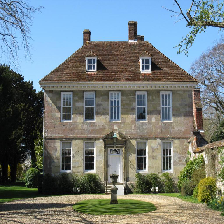

In [31]:
# 変換前の画像の表示
img_test

**リスト11.17:画像の変換**

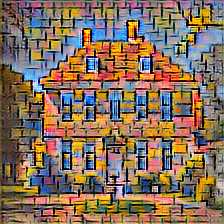

In [32]:
# モデルの適用
pred = model_gen.predict(img_arr_test) # 学習した変換ネットワークモデルで出力

# 変換後の画像の表示
img_pred = array_to_img(pred.squeeze())
img_pred